In [1]:
%%capture
%%bash
# Install Linux, python then RDKit and openbabel
wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
conda install -q -y -c conda-forge python=3.7
conda install -q -y -c conda-forge rdkit=2020.09.2
conda install -q -y -c openbabel openbabel

pip install py3Dmol

In [2]:
!ldd /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/cDataStructs.so

	linux-vdso.so.1 (0x00007ffdbe718000)
	/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4 (0x00007fe72d1b8000)
	libRDKitDataStructs.so.1 => /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/../../../../libRDKitDataStructs.so.1 (0x00007fe72d0aa000)
	libRDKitRDBoost.so.1 => /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/../../../../libRDKitRDBoost.so.1 (0x00007fe72d550000)
	libRDKitRDGeneral.so.1 => /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/../../../../libRDKitRDGeneral.so.1 (0x00007fe72d52d000)
	libboost_python37.so.1.74.0 => /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/../../../../libboost_python37.so.1.74.0 (0x00007fe72d4f1000)
	libstdc++.so.6 => /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/../../../../libstdc++.so.6 (0x00007fe72cf36000)
	libgcc_s.so.1 => /usr/local/lib/python3.7/site-packages/rdkit/DataStructs/../../../../libgcc_s.so.1 (0x00007fe72d4db000)
	libc.so.6 => /lib/x86_64-linux-gnu/libc.so.6 (0x00007fe72cb45000)
	libunwind.so.

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd

%pylab inline
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

Populating the interactive namespace from numpy and matplotlib


Check py3Dmol is working

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

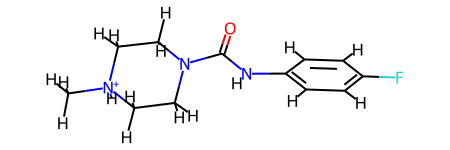

In [4]:
#Generate a mol object from a SMILES string
mol = Chem.MolFromSmiles('C[NH+]1CCN(CC1)C(=O)Nc1ccc(F)cc1') #This is the ligand in the crystal structure
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

In [5]:
# File locations
sdfFilePath = 'asinexSelectionexport.sdf' # The input file of structures to generate conformations from
ConfoutputFilePath = 'asinexSelectionForDocking.sdf' # Output file containing conformations for docking

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

10

In [6]:
#Check that all molecules have a name
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

Conformation generation
We next generate conformations, this uses paralellisation code from http://www.rdkit.org/docs/Cookbook.html contributed by Andrew Dalke. We don't use all cores on a desktop machine or it might be unresponsive. If running on a cluster you should modify this.


In [7]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:02 |###############################|


Docking to Protein
After generating the conformations we can now do the docking. In this example we use smina which can be downloaded from https://sourceforge.net/projects/smina/ you will need to know where smina has been installed. The protein and ligand examples provided are taken from https://fragalysis.diamond.ac.uk/viewer/react/preview/target/MURD MURD-x0373.
Docking using smina
Need protein minus the ligand in pdb format, 
the ligand extracted from binding site in pdb format, 
Conformations to be docked as sdf from conformation generation above
DockedFilePath = 'All_Docked.sdf.gz' is the File for the Docked structures

In [8]:
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static

--2020-12-16 10:37:18--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 216.105.38.13
Connecting to sourceforge.net (sourceforge.net)|216.105.38.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?r=&ts=1608115039&use_mirror=nchc [following]
--2020-12-16 10:37:19--  https://downloads.sourceforge.net/project/smina/smina.static?r=&ts=1608115039&use_mirror=nchc
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|216.105.38.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nchc.dl.sourceforge.net/project/smina/smina.static [following]
--2020-12-16 10:37:20--  https://nchc.dl.sourceforge.net/project/smina/smina.static
Resolving nchc.dl.sourceforge.net (nchc.dl.sourceforge.net)... 140.110.96.69, 2001:e

In [9]:
!chmod u+x smina.static

In [10]:
!./smina.static --help


Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimension (Angstroms)
  --autobox_ligan

Docking using smina
Need protein minus the ligand in pdb format, 
the ligand extracted from binding site in pdb format, 
Conformations to be docked as sdf from conformation generation above
DockedFilePath = 'All_Docked.sdf.gz' is the File for the Docked structures

In [11]:
ProteinForDocking = 'protein_minus_ligand.pdb'
LigandFromProtein = '373ligand_only.pdb'
DockedFilePath = 'All_Docked.sdf.gz'
FlexibleDockedFilePath = 'FlexDocked.sdf.gz'

In [12]:
!'./smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{DockedFilePath}'



   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

Optional, Rescore using a random forest model described in https://www.nature.com/articles/srep46710
Download from https://github.com/oddt/rfscorevs You will need the path to the binary
Path to protein containing ligand in pdb format
protein_plus_373ligand from Diamond
File to store rescored results

In [13]:
!wget http://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
!unzip rf-score-vs_v1.0_linux_2.7.zip
!./rf-score-vs --hy

--2020-12-16 11:16:20--  http://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
Resolving wojcikowski.pl (wojcikowski.pl)... 128.204.218.154
Connecting to wojcikowski.pl (wojcikowski.pl)|128.204.218.154|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip [following]
--2020-12-16 11:16:21--  https://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
Connecting to wojcikowski.pl (wojcikowski.pl)|128.204.218.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172075220 (164M) [application/zip]
Saving to: ‘rf-score-vs_v1.0_linux_2.7.zip’

rf-score-vs_v1.0_li 100%[===================>] 164.10M  1.48MB/s    in 1m 43s  

2020-12-16 11:18:05 (1.59 MB/s) - ‘rf-score-vs_v1.0_linux_2.7.zip’ saved [172075220/172075220]

Archive:  rf-score-vs_v1.0_linux_2.7.zip
  inflating: README.md               
  inflating: rf-score-vs             
   creating: test/
  inflating: t

In [14]:
#http://wojcikowski.pl/travis/rf-score-vs_v1.0_linux_2.7.zip
TargetProtein = 'protein_plus_373ligand.pdb'
scoreResults = 'DockedRescored.csv'

In [15]:
!./rf-score-vs --receptor '{TargetProtein}' '{DockedFilePath}' -o csv -O '{scoreResults}' --field name --field RFScoreVS_v2

In [16]:
docked_df = PandasTools.LoadSDF(DockedFilePath,molColName='Molecule', removeHs=False)

,minimizedAffinity,ID,Molecule
0,-4.28687,ASN 16454886,
1,-4.06050,ASN 16454886,
2,-3.97042,ASN 16454886,
3,-3.92598,ASN 16454886,
4,-3.88239,ASN 16454886,

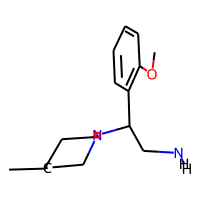
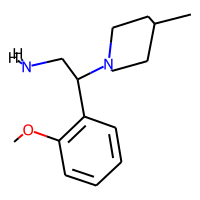
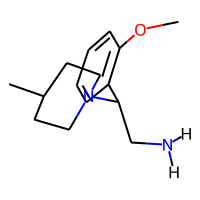
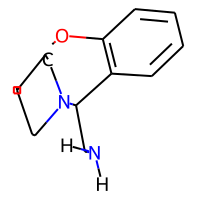
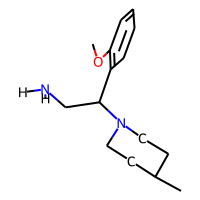

In [17]:
docked_df.head(n=5)

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
0,-4.28687,ASN 16454886,,ASN 16454886,6.099753
1,-4.06050,ASN 16454886,,ASN 16454886,6.118964
2,-3.97042,ASN 16454886,,ASN 16454886,6.100235
3,-3.92598,ASN 16454886,,ASN 16454886,6.084801
4,-3.88239,ASN 16454886,,ASN 16454886,6.145785

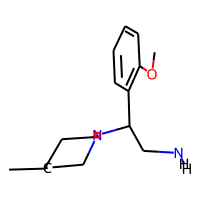
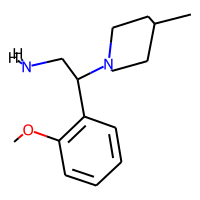
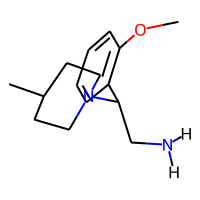
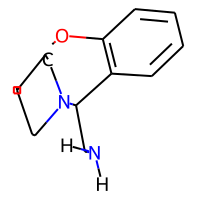
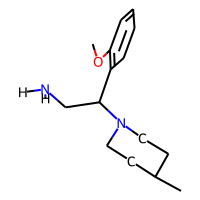

In [18]:
scores_df = pd.read_csv(scoreResults)
results_df = pd.concat([docked_df, scores_df], axis=1)
results_df.head(5)

Saving the results
Now combine rescored file with docked structure file and export to "Alldata.sdf.gz" this is a big file so export compressed

In [19]:
combinedResults = 'Alldata.sdf.gz'
PandasTools.WriteSDF(results_df, combinedResults, molColName="Molecule", idName="ID", properties=list(results_df.columns))

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
133,-3.69493,ASN 10790639,,ASN 10790639,6.348065
366,-6.89228,AEM 10028511,,AEM 10028511,6.242191
344,-4.71378,ART 13967891,,ART 13967891,6.227525
293,-5.04208,ART 13984963,,ART 13984963,6.219512
27,-5.57582,ASN 16454886,,ASN 16454886,6.216000

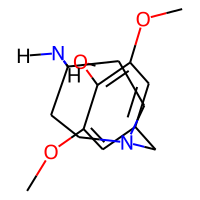
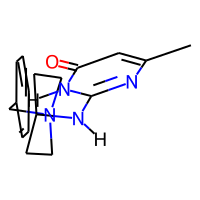
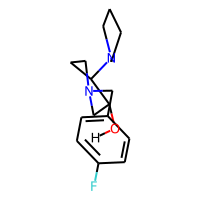
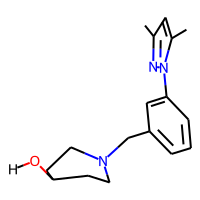
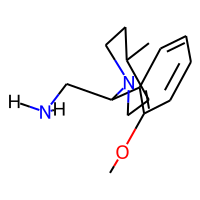

In [20]:
results_df.sort_values(["RFScoreVS_v2"], axis=0, ascending=False, inplace=True) #or sort by scoring function
results_df.head(5)

,minimizedAffinity,ID,Molecule,name,RFScoreVS_v2
356,-7.53870,AEM 10028511,,AEM 10028511,6.180779
383,-7.32533,AEM 10028511,,AEM 10028511,6.132089
384,-7.23960,AEM 10028511,,AEM 10028511,6.213529
357,-7.19520,AEM 10028511,,AEM 10028511,6.185442
358,-7.10358,AEM 10028511,,AEM 10028511,6.186615

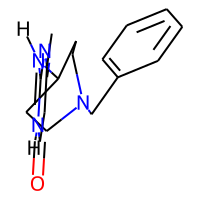
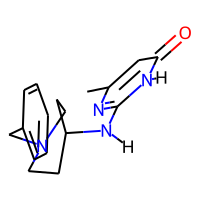
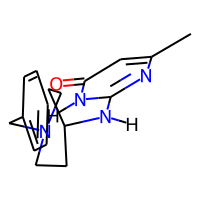
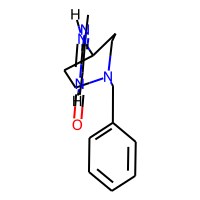
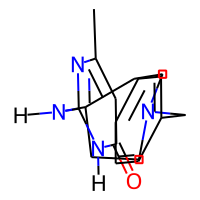

In [21]:
results_df.sort_values(["minimizedAffinity"], axis=0, ascending=False, inplace=True) #or sort by minimizedAffinity
results_df.head(5)

In [22]:
selectedPose = 'selectedpose.sdf'
selectedPoseH = 'selectedposeH.sdf'

Export the top scoring molecules, edit "head(1)" to the number you want to export

In [23]:
PandasTools.WriteSDF(results_df.head(5), selectedPose, molColName="Molecule", idName="ID", properties=list(results_df.columns))

,minimizedAffinity,name,RFScoreVS_v2,ID,Molecule
0,-7.53870,AEM 10028511,6.180779,AEM 10028511,
1,-7.32533,AEM 10028511,6.132089,AEM 10028511,
2,-7.23960,AEM 10028511,6.213529,AEM 10028511,
3,-7.19520,AEM 10028511,6.185442,AEM 10028511,
4,-7.10358,AEM 10028511,6.186615,AEM 10028511,

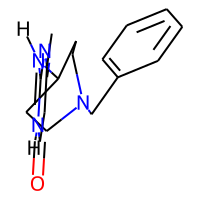
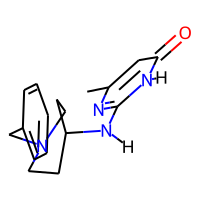
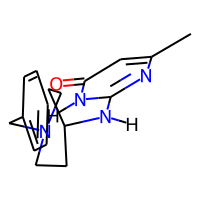
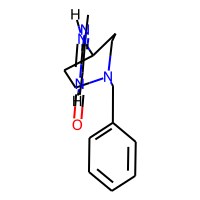
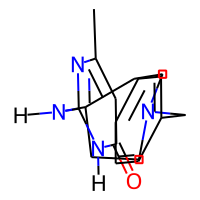

In [24]:
selecteddocked_df = PandasTools.LoadSDF(selectedPose,molColName='Molecule', removeHs=False)
selecteddocked_df

Adding hydrogens


In [25]:
!obabel  -isdf 'selectedpose.sdf'  -osdf   -h  -O 'selectedposeH.sdf'

5 molecules converted


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

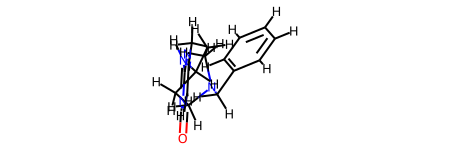

In [26]:
mH = Chem.MolFromMolFile(selectedPoseH, removeHs=False) #View first structure, Hydrogens present
mH

In [27]:
mols = [m for m in Chem.SDMolSupplier(selectedPoseH)]

In [28]:
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer  

Change "mols[0]" to the number of the molecule you want to view

In [29]:
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#another cell